In [ ]:
# laplace-CAN-paper-figures.ipynb
#
# Bryan Daniels
# 2024/2/7

Simulating a continuous attractor network (CAN) that matches with the Laplace
transform picture of Howard et al. 2018.  We have:

   - Units connected in a 1-D topology with marginally stable activity patterns
     that consist of an "edge" at any location along the line
   - The edge moves with speed that scales as $1/t$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize

from laplace_network import asymmetric_laplace_network,gaussian_laplace_network,find_edge_location
import laplace_CAN_figures as lf

from importlib import reload
reload(lf)

<module 'laplace_CAN_figures' from '/Users/bdaniel6/Dropbox (ASU)/Research/laplace-decisions/code/laplace_CAN_figures.py'>

# Demonstrate exponential decay using asymmetric interaction kernel

In [2]:
from laplace_network import asymmetric_edge_states

In [250]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

dateStr = '240513' # used in output figure filenames

sim_type = 'past' #'past' #'future'
Npopulation = 100 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z 
delta_z = 1/4 #1/8 #1/4  
n_0_asymmetric = Npopulation/2 
if sim_type == 'past':
    t_0_asymmetric = 5 #10 
elif sim_type == 'future':
    t_0_asymmetric = -80 #-75

# 2024/3/1 set sigma large compared to range of states for all synapses except edge->edge
sigma_edge = 0.5 #0.25 #0.5 
sigma_other = 20 

# scale of interaction strength between neighbors
J = 2 #4
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = sigma_other/2
# strength of feedback from bump to edge neurons varies with n 
J_bump_edge_abs_max = 1 # 10 # to avoid instability
J_bump_edge_scale_factor_asymmetric = sigma_other
J_bump_edge = [ -J_bump_edge_scale_factor_asymmetric*np.clip(
                    1./t_0_asymmetric*1./delta_z*np.exp(-delta_z*(n-n_0_asymmetric)),
                    -J_bump_edge_abs_max,+J_bump_edge_abs_max) for n in range(Npopulation) ] 

net_asymmetric = asymmetric_laplace_network(
                      Npopulation=Npopulation,
                      J=J,
                      delta_z=delta_z,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      sigma_edge=sigma_edge,
                      sigma_other=sigma_other)

zero_velocity_asymmetric_edge_Jmat: edge_shift = 0.1256244214584455


In [251]:
# run simulation

noise_var = 1e-2 #5e-2 #0 # strength of noise (variance added per unit time)
t_final = t_0_asymmetric + 75
delta_t = 0.01 #0.001 
seed = 12345

# start with edge state at location n_0 at time t_0
edge_t = t_0_asymmetric 
initial_guess_edge = net_asymmetric.J*(2*asymmetric_edge_states(np.arange(0,Npopulation),
                                                                edge_t,
                                                                delta_z=delta_z,
                                                                n_0=n_0_asymmetric,
                                                                t_0=t_0_asymmetric)-1)
edge_state = net_asymmetric.find_edge_state(n_0_asymmetric,
                                 initial_guess_edge=initial_guess_edge,
                                 method='translate')

# simulate dynamics
states_asymmetric = net_asymmetric.simulate_dynamics(edge_state,
                               t_final-t_0_asymmetric,
                               noise_var,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states_asymmetric.index = states_asymmetric.index + t_0_asymmetric

Text(0, 0.5, 'Neural state')

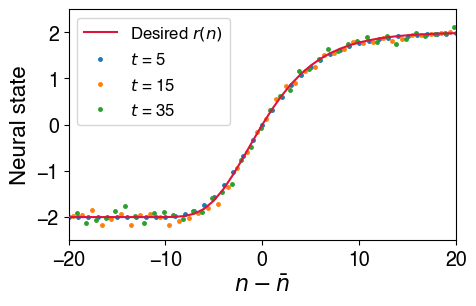

In [252]:
# compare simulated shape of edge to desired shape

plt.figure(figsize=(5,3))

nList = np.arange(0,net_asymmetric.Npopulation)
desired_edge_shape = net_asymmetric.J*(2*asymmetric_edge_states(nList,t_0_asymmetric,
                                                                delta_z=delta_z,
                                                                n_0=n_0_asymmetric,
                                                                t_0=t_0_asymmetric)-1)
desired_edge_offset = find_edge_location(desired_edge_shape,Npopulation)[0]
plt.plot(nList-desired_edge_offset,desired_edge_shape,
         label='Desired $r(n)$',
         color='crimson',
         zorder=+10)

for t in [t_0_asymmetric,
          t_0_asymmetric + 10, #t_0_asymmetric*2,
          t_0_asymmetric + 30, #t_0_asymmetric*4,
         ]:
    edge_offset = np.sort(find_edge_location(states_asymmetric.loc[t],Npopulation))[0]
    plt.plot(nList - edge_offset,
             states_asymmetric.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
                 '.',label="$t$ = {}".format(int(t)),lw=1,ms=5)
plt.axis(xmin=-5/net_asymmetric.delta_z,
         xmax=5/net_asymmetric.delta_z,
         ymin=-net_asymmetric.J-0.5,
         ymax=net_asymmetric.J+0.5)
plt.legend()
plt.xlabel('$n - \\bar n$')
plt.ylabel('Neural state')

In [253]:
reload(lf)

<module 'laplace_CAN_figures' from '/Users/bdaniel6/Dropbox (ASU)/Research/laplace-decisions/code/laplace_CAN_figures.py'>

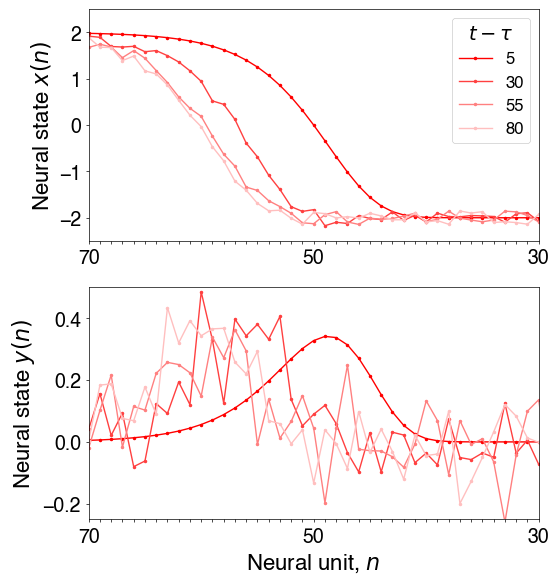

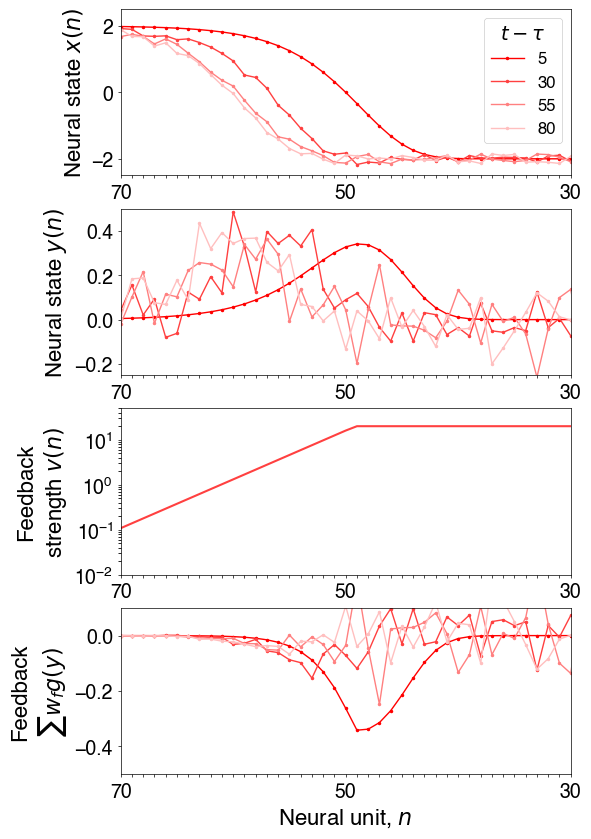

In [254]:
for include_feedback_plots in [False,True]:
    
    # set plot configuration based on simulation settings
    if sim_type == 'past':
        flip_n = True
        colors = [ (1,1-x,1-x) for x in np.linspace(1,0,5) ] # reds
        input_min,input_max = -0.5,0.1
    elif sim_type == 'future':
        flip_n = False
        colors = [ (1-x,1-x,1) for x in np.linspace(1,0,5) ] # blues
        input_min,input_max = -0.1,0.5
    if noise_var > 1e-6: # large noise
        state_min,state_max = -net_asymmetric.J-0.5,net_asymmetric.J+0.5
        bump_state_min,bump_state_max = -0.25,0.5
    else: # small noise
        state_min,state_max = -net_asymmetric.J-0.1,net_asymmetric.J+0.1
        bump_state_min,bump_state_max = 0.,0.4
    
    # make plot
    lf.translation_simulation_plot(net_asymmetric,states_asymmetric,states_asymmetric,
                                   num_neurons_scale=5/net_asymmetric.delta_z,
                                   state_min=state_min,state_max=state_max,
                                   bump_state_min=bump_state_min,bump_state_max=bump_state_max,
                                   include_feedback_plots=include_feedback_plots,
                                   flip_n=flip_n,
                                   colors=colors,
                                   input_min=input_min,input_max=input_max)
    filename = '{}_asymmetric_translation_simulation_{}'.format(dateStr,sim_type)
    if noise_var > 1e-6:
        filename += '_noise'
    if include_feedback_plots:
        filename += '_with_feedback_plots'
    plt.savefig(filename+'.pdf')

In [255]:
reload(lf)

<module 'laplace_CAN_figures' from '/Users/bdaniel6/Dropbox (ASU)/Research/laplace-decisions/code/laplace_CAN_figures.py'>

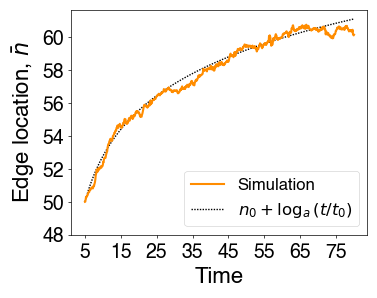

In [256]:
lf.edge_location_plot(net_asymmetric,states_asymmetric,n_0_asymmetric,t_0_asymmetric,delta_z,logscale=False)
plt.xticks(t_0_asymmetric + np.array([0,10,20,30,40,50,60,70]),t_0_asymmetric + np.array([0,10,20,30,40,50,60,70]));
if sim_type == 'past':
    plt.yticks(n_0_asymmetric+np.arange(-2,12,2))
elif sim_type == 'future':
    plt.yticks(n_0_asymmetric-np.arange(-2,12,2))
filename = '{}_asymmetric_edge_location_{}'.format(dateStr,sim_type)
if noise_var > 1e-6:
    filename += '_noise'
plt.savefig(filename+'.pdf')

In [257]:
reload(lf)

<module 'laplace_CAN_figures' from '/Users/bdaniel6/Dropbox (ASU)/Research/laplace-decisions/code/laplace_CAN_figures.py'>

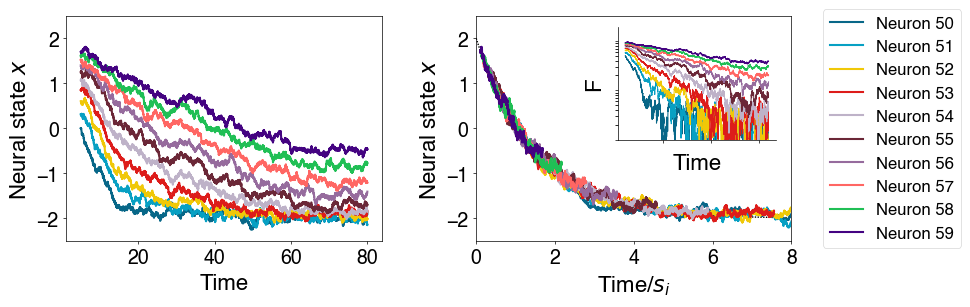

In [258]:
x_max = net_asymmetric.J
lf.time_rescaling_plot(states_asymmetric,n_0_asymmetric,t_0_asymmetric,delta_z,x_max,
                       state_min=-net_asymmetric.J-0.5,state_max=net_asymmetric.J+0.5,
                       delta_n=int(1/delta_z/4),sim_type=sim_type)

# also plot analytical result as dotted line
analytical_times = np.linspace(0,10*t_0_asymmetric,1000)
plt.plot(analytical_times,
         x_max*( 2 * asymmetric_edge_states(0,analytical_times,
                                                       delta_z=delta_z,
                                                       n_0=0,
                                                       t_0=np.sign(t_0_asymmetric)) - 1 ),
         'k',
         zorder=-10,
         lw=1,
         ls=(0,(1,1)) )
filename = '{}_asymmetric_time_rescaling_{}'.format(dateStr,sim_type)
if noise_var > 1e-6:
    filename += '_noise'
plt.savefig(filename+'.pdf')

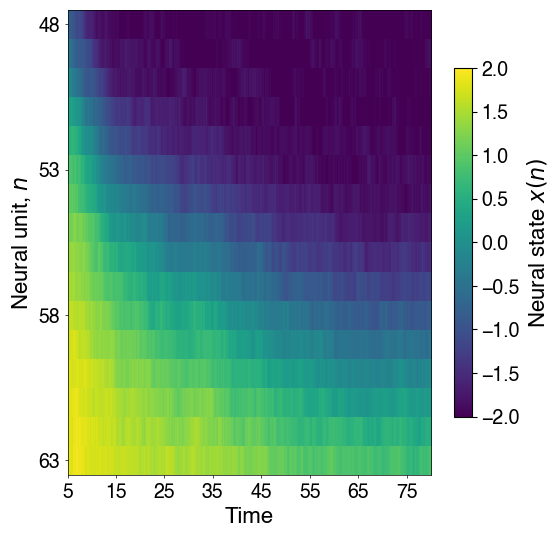

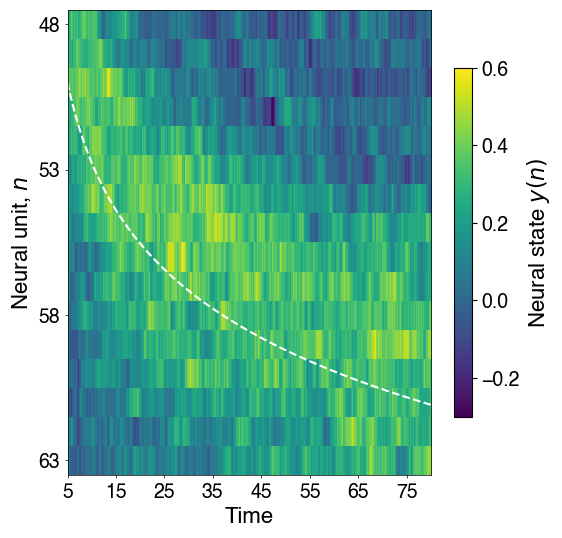

In [259]:
# 2024/1/18 make 2D heat-map plot for "edge" and "bump" neurons
for neuronType in ['edge','bump']:
    fig = plt.figure(figsize=(6,6))
    if sim_type == 'past':
        neuronMin,neuronMax = 50-2,50+14
    elif sim_type == 'future':
        neuronMin,neuronMax = 50-14+1,50+2+1
    if neuronType == 'edge': # "edge" neurons
        plt.matshow(states_asymmetric.T[neuronMin:neuronMax+1],fignum=fig,vmin=-2,vmax=+2)
        stateName = '$x$'
    elif neuronType == 'bump': # "bump" neurons
        plt.matshow(states_asymmetric.T[Npopulation+neuronMin:Npopulation+neuronMax+1],fignum=fig,vmin=-0.3,vmax=0.6)
        stateName = '$y$'
        # also plot desired edge location as a dashed white line
        t_to_index = lambda t: (t - t_0_asymmetric)/delta_t
        n_to_index = lambda n: n - neuronMin
        theory_data = n_0_asymmetric+1./delta_z*np.log(states_asymmetric.index/t_0_asymmetric)
        plt.plot(t_to_index(states_asymmetric.index),n_to_index(theory_data),'w--')
    else:
        raise Exception("unrecognized neuronType")
    plt.gca().set_aspect(600)
    plt.gca().xaxis.tick_bottom()
    
    plt.xticks(range(0,8000,1000),range(t_0_asymmetric,t_0_asymmetric+80,10))
    plt.yticks(range(0,neuronMax-neuronMin,5),range(neuronMin,neuronMax,5))
    plt.axis(ymin=neuronMax-neuronMin-0.5,ymax=-0.5,)
    plt.xlabel('Time')
    plt.ylabel('Neural unit, $n$')
    plt.colorbar(shrink=0.75,label='Neural state {}$(n)$'.format(stateName))
    #plt.axis(ymin=70,ymax=40)
    #fig.subplots_adjust(bottom=0.9,top=0.95) # doesn't do anything?
    lf.defaultFigure.makePretty()
    filename = '{}_{}_neuron_firing_rate_vs_cell_and_time_{}'.format(dateStr,neuronType,sim_type)
    if noise_var > 1e-6:
        filename += '_noise'
    plt.savefig(filename+'.pdf')

# Demonstrate geometric series of timescales using symmetric kernel

In [23]:
def states2rates(states):
    return 0.5*(1.+np.tanh(states))

In [24]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation_symmetric = 100 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z 
delta_z = 1/4 
# scale of interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n
t_0_symmetric = 10
n_0_symmetric = Npopulation_symmetric/2 
J_bump_edge_max = 10 # to avoid instability
J_bump_edge_scale_factor_symmetric = 1 
J_bump_edge = [ -J_bump_edge_scale_factor_symmetric*min(1./t_0_symmetric*1./delta_z*np.exp(-delta_z*(n-n_0_symmetric)),
                                              J_bump_edge_max) for n in range(Npopulation_symmetric) ]
kernel_width = 2 
sigma = 1. 

net_symmetric = gaussian_laplace_network(
                      Npopulation=Npopulation_symmetric,
                      J=J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      kernel_width=kernel_width,
                      sigma=sigma)

In [25]:
# run simulation

noise_var = 1e-6 #1e-4 # strength of noise (variance added per unit time)
i_final = 7 #6 #(t increases exponentially with i) 
t_final = t_0_symmetric + 2**(i_final-1)
delta_t = 0.01 #0.001
seed = 12345

# start with edge state at location n_0 at time t_0
edge_state = net_symmetric.find_edge_state(n_0_symmetric)
    
# simulate dynamics
states_symmetric = net_symmetric.simulate_dynamics(edge_state,
                               t_final-t_0_symmetric,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states_symmetric.index = states_symmetric.index + t_0_symmetric
rates_symmetric = states2rates(states_symmetric)

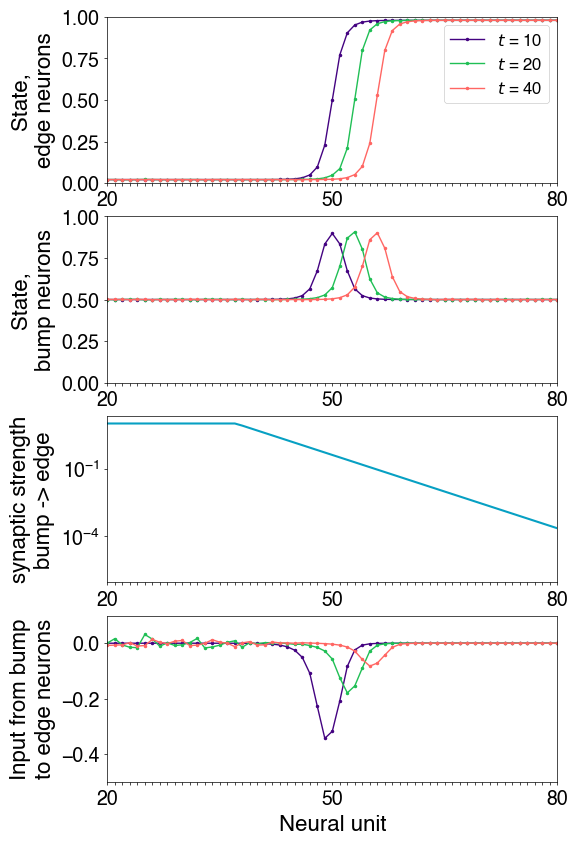

In [49]:
lf.translation_simulation_plot(net_symmetric,rates_symmetric,states_symmetric,
                            state_min=0,state_max=1)
plt.savefig('240214_symmetric_translation_simulation.pdf')

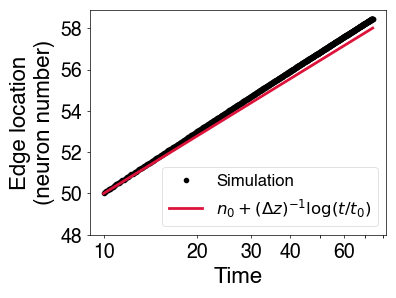

In [60]:
lf.edge_location_plot(net_symmetric,states_symmetric,n_0_symmetric,t_0_symmetric,delta_z)
plt.xticks(t_0_symmetric*np.array([1,2,3,4,6]),t_0_symmetric*np.array([1,2,3,4,6]));
plt.yticks(n_0_symmetric+np.arange(-2,10,2));
plt.savefig('240214_symmetric_edge_location.pdf')

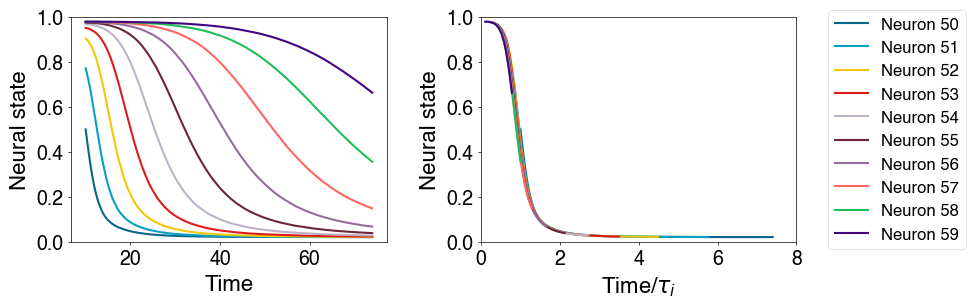

In [53]:
lf.time_rescaling_plot(rates_symmetric,n_0_symmetric,t_0_symmetric,delta_z,
                   state_min=0,state_max=1,
                   delta_n=int(1/delta_z/4))
plt.savefig('240214_symmetric_time_rescaling.pdf')